# Introduction

The goal of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one's aren't. This classification task is important for helping first responders and news organizations detect and respond to real disasters quickly.

In [23]:
# Important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning and Preprocessing
from imblearn.over_sampling import SMOTE


# Data
The training dataset consists of 7,613 tweets each of which is hand classified with either a 1 representing a real disaster or 0 representing not-real disaster. The tweets each have a unique id and three features: text, keyword (possibly blank), and the location of the tweet (possibly blank). The test dataset contains 3,263 tweets with the same features but no labels

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [3]:
test_df = pd.read_csv('test.csv')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


# Exploratory Data Analysis
I will look at some example tweets and create some visualizations of the training dataset to inform my plan of creating a machine learning model.

In [16]:
sample_disaster_tweets = train_df[train_df['target']==1].head(5)
print(np.array(sample_disaster_tweets['text']))

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


The five sample tweets about real disasters all contain capital letters, punctuation, numbers, and stopwords. Typically, natural language processing removes all of these from the text before training the model. Two of the tweets, however, contain a hashtag with the name of of a natural disaster. It may be worth considering hashtags separately rather than removing them with other punctuation marks.

In [12]:
sample_nondisaster_tweets = train_df[train_df['target']==0]['text'].head(5)
print(np.array(sample_nondisaster_tweets))

["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is so fast'
 'What a goooooooaaaaaal!!!!!!']


The five sample non-disaster tweets also contain capital letters, punctuation, and stop words. The non-disaster tweets seem pretty innocuous, with feature extraction my model should be able to classify tweets related to disasters. 

In [19]:
disaster_tweets_with_keywords = train_df[(train_df['target']==1)&(train_df['keyword'].notna())].head(5)
print(np.array(disaster_tweets_with_keywords['text']))
print(np.array(disaster_tweets_with_keywords['keyword']))
print(np.array(disaster_tweets_with_keywords['location']))

['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA'
 'Barbados #Bridgetown JAMAICA \x89ÛÒ Two cars set ablaze: SANTA CRUZ \x89ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J'
 'How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr']
['ablaze' 'ablaze' 'ablaze' 'ablaze' 'ablaze']
['Birmingham' 'AFRICA' 'World Wide!!' nan 'GREENSBORO,NORTH CAROLINA']


In [20]:
nondisaster_tweets_with_keywords = train_df[(train_df['target']==0)&(train_df['keyword'].notna())].head(5)
print(np.array(nondisaster_tweets_with_keywords['text']))
print(np.array(nondisaster_tweets_with_keywords['keyword']))
print(np.array(nondisaster_tweets_with_keywords['location']))

['We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw'
 'Crying out for more! Set me ablaze'
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N'
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season."
 'Ablaze for you Lord :D']
['ablaze' 'ablaze' 'ablaze' 'ablaze' 'ablaze']
['Est. September 2012 - Bristol' 'Philadelphia, PA' 'London, UK'
 'Pretoria' 'Paranaque City']


Comparing disaster tweets with nondisaster tweets for the keyword 'ablaze' reveals more about necessary NLP steps and the differences between the two categories. Some of the tweets have URLs which will need to be removed as part of data cleaning. The disaster tweets in these examples contain location names in the text much more commonly. Both categories contain location features.

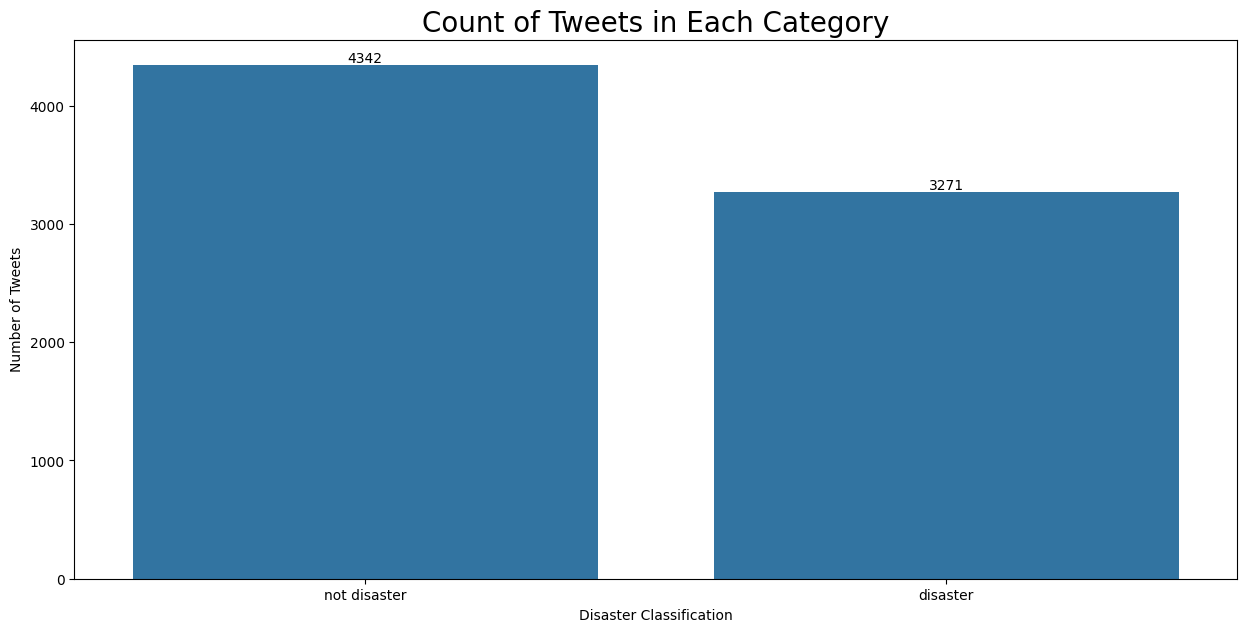

In [24]:
# Compare the frequency of the two categories
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , x=train_df['target'])

plt.xlabel('Disaster Classification')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0,1], labels=['not disaster', 'disaster'])
plt.title('Count of Tweets in Each Category', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

The two categories are imbalanced. This could cause our model to be biased towards the not disaster category. It could also cause metrics such as accuracy to be misleading. To mitigate these issues the categories can be rebalanced using one of a few strategies:
* Resampling: undersample the majority class and/or oversample the minority class
* Synthetic Minority Oversampling Technique (SMOTE)  

Undersampling could remove valuable data. SMOTE creates synthetic data for the minority class using k-nearest neighbors to a random point. I will use SMOTE because random oversampling can lead to poor generalization of the model

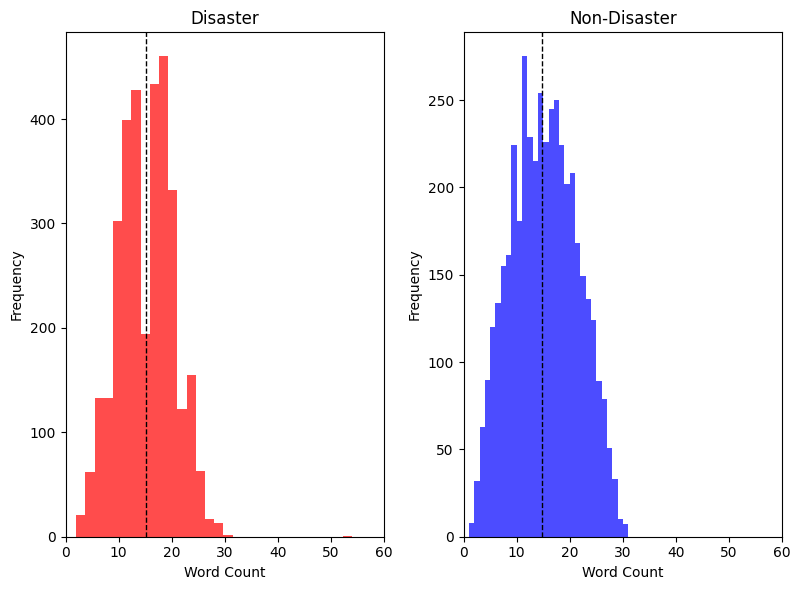

In [30]:
def get_word_count(tweet: str) -> int:
    return len(tweet.split(' '))

disaster_word_counts = train_df[train_df['target']==1]['text'].apply(get_word_count)
mean_disaster_word_count = np.mean(disaster_word_counts, axis=0)

nondisaster_word_counts = train_df[train_df['target']==0]['text'].apply(get_word_count)
mean_nondisaster_word_count = np.mean(nondisaster_word_counts, axis=0)

plt.figure(figsize=(12, 6))

# Plot histogram of disaster word counts
plt.subplot(1, 3, 1)
plt.hist(disaster_word_counts, bins=30, color='r', alpha=0.7)
plt.axvline(mean_disaster_word_count, color='k', linestyle='dashed', linewidth=1)
plt.title('Disaster')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 60)

# Plot histogram of nondisaster word counts
plt.subplot(1, 3, 2)
plt.hist(nondisaster_word_counts, bins=30, color='b', alpha=0.7)
plt.axvline(mean_nondisaster_word_count, color='k', linestyle='dashed', linewidth=1)
plt.title('Non-Disaster')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 60)

plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing

In [ ]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)

# Citations
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/#:~:text=There%20are%20several%20ways%20to,Minority%20Over%2Dsampling%20Technique).

